# Altitude Data Engineering
Geo vis group - predicting sea level rise

Overview:

- **get_gdal** Given a latitude / longitude (gps) coordinate pair, download the corresponding GDAL image of the geography.
    - if needed, make multiple smaller requests in order to download entire dataset, and combine them into one
- **map_altitudes** Given a GDAL image and X altitude ranges (eg: 0 - 10 meters, 10 - 20 meters, etc.), output polygon shape coordinates on the map for the given altitude ranges.
    - keep GPS coordinates in final polygon dataset
    - Idea: Multipass sparse matrix with convolutions
- **combine_polygons** Given two polygons and their gps coordinates, combine them into a single shape with gps coordinates loadable into mapbox. 



In [1]:
#example to download packages
#import sys
#!{sys.executable} -m pip install elevation

In [225]:
from osgeo import gdal
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import elevation 
import queue
import bisect
import math

In [2]:
!eio selfcheck

Your system is ready.


In [507]:
#create our dataset

#hawaii big island data
#bl = [-156.09,18.00] #bottom left lon /lat
#tr = [-154.81,21.00] #top right lon /lat

#elevation.clip(bounds=(bl[0], bl[1], tr[0], tr[1]), output='data/locations/hawaii_big_island.tif')
#elevation.clean()

#See: https://github.com/bopen/elevation
#or run: 
#eio clip -o Hawaii.tif --bounds -156.09 19.00 -154.81 20.26

#the format is: 
#eio clip -o Hawaii.tif --bounds long1 lat1 long2 lat2
# Below we have long1 -156.70 and lat1 20.78
!eio clip -o Maui.tif --bounds -156.45 20.650 -156.33 20.80


make: Entering directory '/home/esca/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/esca/.cache/elevation/SRTM1'
make: Entering directory '/home/esca/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/esca/.cache/elevation/SRTM1'
make: Entering directory '/home/esca/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.6c4e72578df8445ebe7d069427d37bda.vrt
make: Leaving directory '/home/esca/.cache/elevation/SRTM1'
make: Entering directory '/home/esca/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -156.45 20.8 -156.33 20.65 SRTM1.6c4e72578df8445ebe7d069427d37bda.vrt /home/esca/w209/bk/geo-viz-group-elevation/geo-viz-group-elevation/Maui.tif
rm -f SRTM1.6c4e72578df8445ebe7d069427d37bda.vrt
make: Leaving directory '/home/esca/.cache/elevation/SRTM1'


In [508]:
#TODO, create custom rects for each of these 
#elevations
#export these as datasets (geocoordinates)
levels = list(range(0, 80, 10))

#from coordinates (bottom-left --> top-right) -156.09 19.00 -154.81 20.26
#filename = "data/Hawaii.tif"
filename = "/home/esca/w209/bk/geo-viz-group-elevation/geo-viz-group-elevation/Maui.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

data_array = np.flip(data_array, axis=0)    
    
print(data_array.shape)

#save to csv
#np.savetxt("data/locations/hawaii_big_island.csv", data_array, delimiter=",")


sliced = []
for x in range(0,data_array.shape[0],100):
    sliced_x = []
    for y in range(0,data_array.shape[1],100):
        #print(data_array[x][y])
        sliced_x.append(data_array[x][y])
    sliced.append(sliced_x)

(540, 432)


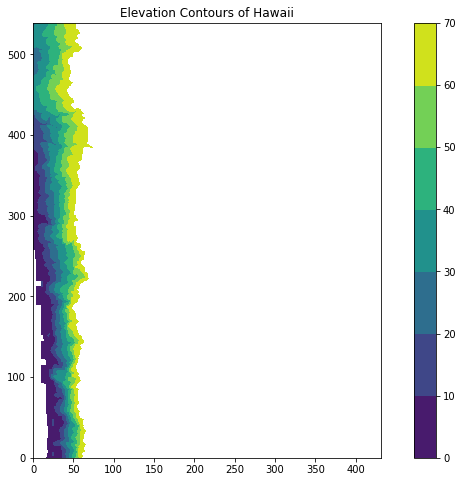

In [509]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = levels)
plt.title("Elevation Contours of Hawaii")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [510]:
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [511]:
class PolyMapBFS: 
  
    def __init__(self, g): 
        self.grid = g 
        self.hmap = {}
  

    def getPoly(self, grid, low, hi):

        hmap = {}
        hmap2 = {}
        hlist = []   
        hlist2 = []   
        jointlist = []   
        q = queue.Queue()

        for i in range(len(grid)):

            for j in range(len(grid[0])):
                if ((grid[i][j] >= low) and (grid[i][j] <= hi)):
                    grid[i][j] = -9999
                    q.put((i, j))
                    if hmap.get(i) == None :
                        hmap[i] = [j]
                    else :
                        hmap[i].append(j)                    
                    if hmap2.get(j) == None :
                        hmap2[j] = [i]
                    else :
                        hmap2[j].append(i)                            
                    while (q.empty() != True):
                        qtuple = q.get()
                        i = qtuple[0]
                        j = qtuple[1]
                        if (i-1 >= 0 and ((grid[i-1][j] >= low) and (grid[i-1][j] <= hi))):
                            q.put((i-1, j))
                            grid[i-1][j] = -9999
                            if hmap.get(i-1) == None :
                                hmap[i-1] = [j]
                            else :
                                bisect.insort(hmap[i-1], j)                            
                            if hmap2.get(j) == None :
                                hmap2[j] = [i-1]
                            else :
                                bisect.insort(hmap2[j], i-1) 
                        if (i+1 < len(grid) and ((grid[i+1][j] >= low) and (grid[i+1][j] <= hi))):
                            q.put((i+1, j))
                            grid[i+1][j] = -9999                          
                            if hmap.get(i+1) == None :
                                hmap[i+1] = [j]
                            else :
                                bisect.insort(hmap[i+1], j) 
                            if hmap2.get(j) == None :
                                hmap2[j] = [i+1]
                            else :                             
                                bisect.insort(hmap2[j], i+1) 
                        if (j-1 >= 0 and ((grid[i][j-1] >= low) and (grid[i][j-1] <= hi))):
                            q.put((i, j-1))
                            grid[i][j-1] = -9999    
                            if hmap.get(i) == None :
                                hmap[i] = [j-1]
                            else : 
                                bisect.insort(hmap[i], j-1)                                 
                            if hmap2.get(j-1) == None :
                                hmap2[j-1] = [i]
                            else : 
                                bisect.insort(hmap2[j-1], i)                                 
                        if (j+1 < len(grid[0]) and ((grid[i][j+1] >= low) and (grid[i][j+1] <= hi))):
                            q.put((i, j+1))
                            grid[i][j+1] = -9999     
                            if hmap.get(i) == None :
                                hmap[i] = [j+1]
                            else :  
                                bisect.insort(hmap[i], j+1)                                  
                            if hmap2.get(j+1) == None :
                                hmap2[j+1] = [i]
                            else :       
                                bisect.insort(hmap2[j+1], i)                                     

                    hlist.append(hmap)
                    hlist2.append(hmap2)
                    hmap = {}
                    hmap2 = {}
                    
        
        jointlist.append(hlist)
        jointlist.append(hlist2)
        
        return jointlist

    def getCoord(self, jlist):
    
        coord = []
        theta = 0.0
        cur_theta = 0.0

        top = jlist[0][0].keys()[0]
        bot = jlist[0][0].keys()[-1]

        for x in jlist[0][0]:

            if (len(coord) >= 1):
                cur_theta = math.atan2((coord[-1][0] - x),(coord[-1][1] - jlist[0][0][x][0]))
     
                if (isclose(cur_theta, theta, rel_tol=1e-3)):
                    coord[-1] = (jlist[0][0][x][0],x)
                else:
                    coord.append((jlist[0][0][x][0],x))
                theta = cur_theta
            else:
                coord.append((jlist[0][0][x][0],x))

        for y in range(jlist[0][0][bot][0]+1, jlist[0][0][bot][-1]):           


            cur_theta = math.atan2((coord[-1][0] - jlist[1][0][y][-1]),(coord[-1][1] - y) )


            if (isclose(cur_theta, theta, rel_tol=1e-3)):            
                coord[-1] = (y,jlist[1][0][y][-1])
            else:
                coord.append(y,(jlist[1][0][y][-1]))
            theta = cur_theta


        dlist = jlist[0][0].keys()       

        for x in reversed(dlist):

            cur_theta = math.atan2( (coord[-1][0] - x),(coord[-1][1] - jlist[0][0][x][-1]))


            if (isclose(cur_theta, theta, rel_tol=1e-3)):                
                coord[-1] = (jlist[0][0][x][-1],x)
            else:
                coord.append((jlist[0][0][x][-1],x))
            theta = cur_theta


        for y in range(jlist[0][0][top][-1]-1, jlist[0][0][top][0]-1, -1):           

            cur_theta = math.atan2((coord[-1][0] - jlist[1][0][y][0]),(coord[-1][1] - y))

            if (isclose(cur_theta, theta, rel_tol=1e-3)):            
                coord[-1] = (y,jlist[1][0][y][0])
            else:
                coord.append((y,jlist[1][0][y][0]))

            theta = cur_theta
            
        return coord


In [482]:
pm = PolyMapBFS(data_array)

In [512]:
thePoly = pm.getPoly(data_array, 40, 50)

In [513]:
thePoly

[[{0: [49, 50, 51, 52, 53],
   1: [49, 50, 51, 52, 53],
   2: [49, 50, 51, 52, 53, 54],
   3: [49, 50, 51, 52, 53, 54],
   4: [50, 51, 52, 53, 54],
   5: [50, 51, 52, 53, 54],
   6: [51, 52, 53, 54],
   7: [51, 52, 53, 54, 55],
   8: [53, 54, 55],
   9: [53, 54, 55],
   10: [52, 53, 54],
   11: [51, 52, 53, 54],
   12: [51, 52, 53, 54, 55],
   13: [50, 51, 52, 53, 54],
   14: [49, 50, 51, 52, 53, 54],
   15: [48, 49, 50, 51, 52, 53],
   16: [48, 49, 50, 51, 52, 55, 56],
   17: [48, 49, 50, 51, 52, 53, 54, 55],
   18: [50, 51, 52, 53, 54],
   19: [52, 53, 54, 55],
   20: [53, 54, 55],
   21: [52, 53, 54, 55],
   22: [50, 51, 52, 53, 54, 55],
   23: [49, 50, 51, 52, 53, 54],
   24: [49, 50, 51, 52, 53, 54],
   25: [49, 50, 51, 52, 53],
   26: [49, 50, 51, 52, 53],
   27: [49, 50, 51, 52, 53, 54],
   28: [49, 50, 51, 52, 53, 54],
   29: [50, 51, 52, 53, 54, 55],
   30: [51, 52, 53, 54, 55, 56],
   31: [51, 52, 53, 54, 55, 56],
   32: [51, 52, 53, 54, 55],
   33: [51, 52, 53, 54, 55],
   3

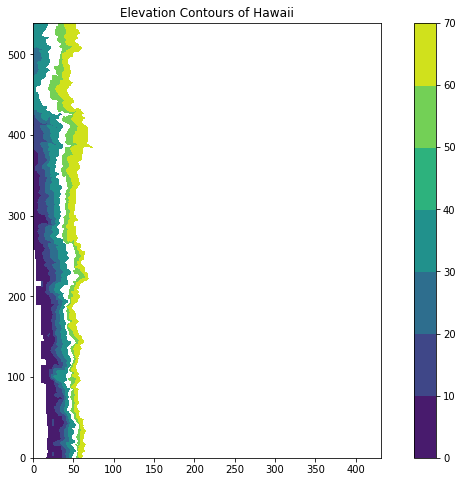

In [514]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = levels)
plt.title("Elevation Contours of Hawaii")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [515]:
thePoly30 = pm.getPoly(data_array, 30,40)
thePoly30

[[{0: [46, 47, 48],
   1: [46, 47, 48],
   2: [46, 47, 48],
   3: [45, 46, 47, 48],
   4: [45, 46, 47, 48, 49],
   5: [45, 46, 47, 48, 49],
   6: [46, 47, 48, 49, 50],
   7: [47, 48, 49, 50],
   8: [48, 49, 50, 51, 52],
   9: [48, 49, 50, 51, 52],
   10: [47, 48, 49, 50, 51],
   11: [46, 47, 48, 49, 50],
   12: [46, 47, 48, 49, 50],
   13: [45, 46, 47, 48, 49],
   14: [43, 44, 45, 46, 47, 48],
   15: [43, 44, 45, 46, 47],
   16: [43, 44, 45, 46, 47],
   17: [41, 42, 43, 44, 45, 46, 47],
   18: [41, 42, 43, 44, 45, 46, 47, 48, 49],
   19: [43, 44, 45, 46, 47, 48, 49, 50, 51],
   20: [46, 47, 48, 49, 50, 51, 52],
   21: [46, 47, 48, 49, 50, 51],
   22: [46, 47, 48, 49],
   23: [46, 47, 48],
   24: [46, 47, 48],
   25: [46, 47, 48],
   26: [45, 46, 47, 48],
   27: [44, 45, 46, 47, 48],
   28: [44, 45, 46, 47, 48],
   29: [44, 45, 46, 47, 48, 49],
   30: [44, 45, 46, 47, 48, 49, 50],
   31: [44, 45, 46, 47, 48, 49, 50],
   32: [45, 46, 47, 48, 49, 50],
   33: [44, 45, 46, 47, 48, 49, 50],


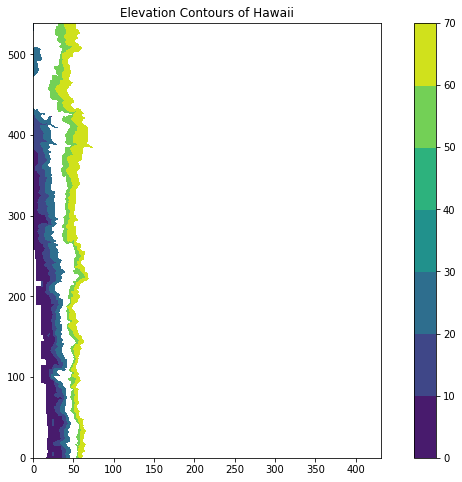

In [516]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = levels)
plt.title("Elevation Contours of Hawaii")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [517]:
thePoly20 = pm.getPoly(data_array, 10,20)
thePoly20

[[{0: [37, 38, 39, 40, 41],
   1: [37, 38, 39, 40, 41],
   2: [37, 38, 39, 40, 41],
   3: [37, 38, 39, 40, 41],
   4: [36, 37, 38, 39, 40],
   5: [36, 37, 38, 39, 40],
   6: [36, 37, 38, 39, 40, 41],
   7: [37, 38, 39, 40, 41],
   8: [37, 38, 39, 40, 41, 42],
   9: [37, 38, 39, 40, 41, 42],
   10: [36, 37, 38, 39, 40, 41],
   11: [36, 37, 38, 39, 40, 41],
   12: [36, 37, 38, 39, 40],
   13: [36, 37, 38, 39],
   14: [36, 37, 38],
   15: [35, 36, 37],
   16: [27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
   17: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
   18: [26, 27, 28, 29, 30, 31, 32, 33, 34],
   19: [27, 28, 29, 30, 31, 32, 33, 34],
   20: [28, 29, 30, 31, 32, 33, 34, 35],
   21: [30, 31, 32, 33, 34, 35, 36, 37, 38],
   22: [34, 35, 36, 37, 38, 39],
   23: [36, 37, 38, 39, 40, 41],
   24: [36, 37, 38, 39, 40, 41],
   25: [35, 36, 37, 38, 39, 40],
   26: [34, 35, 36, 37, 38, 39],
   27: [34, 35, 36, 37, 38, 39],
   28: [35, 36, 37, 38, 39],
   29: [35, 36, 37, 38],
   30: [35, 36, 37, 38],

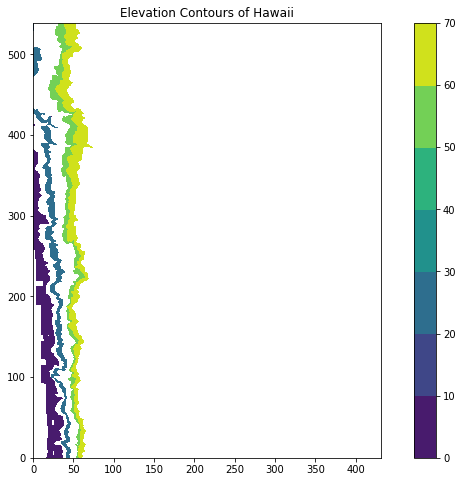

In [518]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = levels)
plt.title("Elevation Contours of Hawaii")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [519]:
thePoly20[0]

[{0: [37, 38, 39, 40, 41],
  1: [37, 38, 39, 40, 41],
  2: [37, 38, 39, 40, 41],
  3: [37, 38, 39, 40, 41],
  4: [36, 37, 38, 39, 40],
  5: [36, 37, 38, 39, 40],
  6: [36, 37, 38, 39, 40, 41],
  7: [37, 38, 39, 40, 41],
  8: [37, 38, 39, 40, 41, 42],
  9: [37, 38, 39, 40, 41, 42],
  10: [36, 37, 38, 39, 40, 41],
  11: [36, 37, 38, 39, 40, 41],
  12: [36, 37, 38, 39, 40],
  13: [36, 37, 38, 39],
  14: [36, 37, 38],
  15: [35, 36, 37],
  16: [27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
  17: [26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
  18: [26, 27, 28, 29, 30, 31, 32, 33, 34],
  19: [27, 28, 29, 30, 31, 32, 33, 34],
  20: [28, 29, 30, 31, 32, 33, 34, 35],
  21: [30, 31, 32, 33, 34, 35, 36, 37, 38],
  22: [34, 35, 36, 37, 38, 39],
  23: [36, 37, 38, 39, 40, 41],
  24: [36, 37, 38, 39, 40, 41],
  25: [35, 36, 37, 38, 39, 40],
  26: [34, 35, 36, 37, 38, 39],
  27: [34, 35, 36, 37, 38, 39],
  28: [35, 36, 37, 38, 39],
  29: [35, 36, 37, 38],
  30: [35, 36, 37, 38],
  31: [34, 35, 36, 37, 38],
  

In [520]:
thePoly20[1][0][0]

[386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426]

In [494]:
coord = pm.getCoord(thePoly20)

(426, 1)
(-0.7865732509881922, -0.7865732509881922)


In [495]:
coord

[(37, 0),
 (37, 3),
 (36, 4),
 (36, 6),
 (37, 7),
 (37, 9),
 (36, 10),
 (36, 14),
 (35, 15),
 (27, 16),
 (26, 17),
 (26, 18),
 (28, 20),
 (30, 21),
 (34, 22),
 (36, 23),
 (36, 24),
 (34, 26),
 (34, 27),
 (35, 28),
 (35, 29),
 (35, 30),
 (34, 31),
 (34, 32),
 (33, 33),
 (33, 34),
 (33, 35),
 (36, 38),
 (38, 39),
 (38, 40),
 (39, 41),
 (39, 42),
 (39, 43),
 (39, 44),
 (39, 45),
 (38, 46),
 (38, 47),
 (37, 48),
 (37, 49),
 (37, 50),
 (37, 51),
 (35, 52),
 (32, 53),
 (31, 54),
 (31, 55),
 (28, 58),
 (28, 60),
 (27, 61),
 (27, 63),
 (29, 64),
 (29, 66),
 (30, 67),
 (30, 68),
 (34, 72),
 (36, 73),
 (37, 74),
 (36, 75),
 (29, 76),
 (27, 78),
 (28, 79),
 (31, 80),
 (31, 81),
 (30, 82),
 (30, 83),
 (29, 84),
 (30, 85),
 (30, 86),
 (29, 87),
 (29, 88),
 (28, 89),
 (28, 90),
 (27, 91),
 (27, 95),
 (26, 96),
 (24, 97),
 (21, 100),
 (21, 103),
 (22, 104),
 (20, 106),
 (20, 107),
 (21, 108),
 (21, 109),
 (24, 110),
 (25, 111),
 (25, 112),
 (26, 113),
 (26, 114),
 (27, 115),
 (33, 116),
 (32, 117),
 

In [523]:
thePoly5060 = pm.getPoly(data_array, 50,60)
thePoly5060

[[{0: [54, 55, 56, 57],
   1: [54, 55, 56, 57],
   2: [55, 56],
   3: [55],
   4: [55],
   5: [55, 56],
   6: [55, 56],
   7: [56, 57],
   8: [56],
   9: [56],
   10: [55, 56, 57],
   11: [55, 56],
   12: [56, 57],
   13: [55, 56, 57],
   14: [55, 56],
   15: [54, 55, 56, 57],
   16: [53, 54, 57, 58, 59],
   17: [56, 57, 58],
   18: [55, 56, 57, 58, 59],
   19: [56, 57, 58, 59],
   20: [56, 57, 58, 59],
   21: [56, 57, 58, 59],
   22: [56, 57, 58, 59],
   23: [55, 56, 57, 58, 59],
   24: [55, 56, 57, 58, 59],
   25: [54, 55, 56, 57, 58],
   26: [54, 55, 56, 57, 58],
   27: [55, 56, 57, 58],
   28: [55, 56, 57, 58],
   29: [56, 57, 58, 59],
   30: [57, 58, 59, 60],
   31: [57, 58],
   32: [56, 57, 58],
   33: [56, 57, 58, 59, 60, 61],
   34: [56, 57, 58, 59, 60],
   35: [57, 58, 59],
   36: [57, 58, 59],
   37: [57, 58, 59],
   38: [58, 59],
   39: [58, 59],
   40: [58],
   41: [58],
   42: [56, 57, 58],
   43: [56, 57],
   44: [55, 56, 57],
   45: [54, 55, 56],
   46: [54, 55, 56],
   

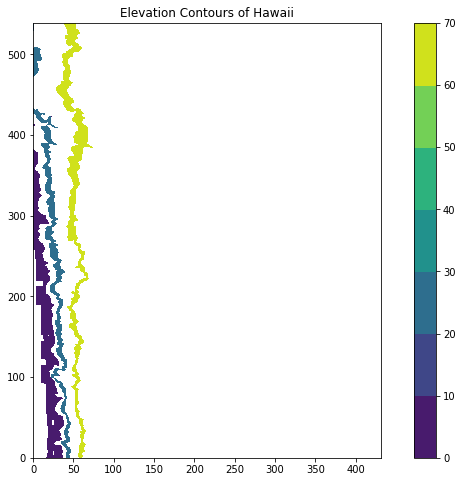

In [524]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = levels)
plt.title("Elevation Contours of Hawaii")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [525]:
coord = pm.getCoord(thePoly5060)
coord

[(54, 0),
 (54, 1),
 (55, 2),
 (55, 6),
 (56, 7),
 (56, 9),
 (55, 10),
 (55, 11),
 (56, 12),
 (55, 13),
 (55, 14),
 (53, 16),
 (56, 17),
 (55, 18),
 (56, 19),
 (56, 22),
 (55, 23),
 (55, 24),
 (54, 25),
 (54, 26),
 (55, 27),
 (55, 28),
 (57, 30),
 (57, 31),
 (56, 32),
 (56, 34),
 (57, 35),
 (57, 37),
 (58, 38),
 (58, 41),
 (56, 42),
 (56, 43),
 (54, 45),
 (54, 46),
 (53, 47),
 (53, 48),
 (51, 50),
 (51, 51),
 (51, 52),
 (51, 53),
 (51, 54),
 (47, 58),
 (47, 59),
 (47, 60),
 (49, 62),
 (49, 63),
 (49, 64),
 (49, 65),
 (49, 66),
 (49, 67),
 (49, 68),
 (49, 69),
 (49, 70),
 (49, 71),
 (49, 72),
 (47, 74),
 (47, 77),
 (48, 78),
 (48, 82),
 (50, 84),
 (50, 85),
 (48, 86),
 (46, 87),
 (46, 89),
 (47, 90),
 (47, 92),
 (48, 93),
 (48, 95),
 (45, 96),
 (44, 97),
 (44, 98),
 (48, 100),
 (48, 103),
 (48, 103),
 (48, 102),
 (49, 101),
 (52, 100),
 (54, 98),
 (54, 97),
 (52, 95),
 (52, 93),
 (51, 92),
 (51, 91),
 (49, 89),
 (47, 88),
 (48, 87),
 (50, 86),
 (52, 84),
 (51, 83),
 (51, 80),
 (52, 79),

In [526]:
xform = []

for x in coord:
    tlist = []
    tlist.append(-156.45 + (x[0]*xstep))
    tlist.append(20.650 + (ystep *x[1]))
    xform.append(tlist)
xform

[[-156.438, 20.65],
 [-156.438, 20.65034722222222],
 [-156.43777777777777, 20.650694444444444],
 [-156.43777777777777, 20.652083333333334],
 [-156.43755555555555, 20.652430555555554],
 [-156.43755555555555, 20.653125],
 [-156.43777777777777, 20.65347222222222],
 [-156.43777777777777, 20.653819444444444],
 [-156.43755555555555, 20.654166666666665],
 [-156.43777777777777, 20.65451388888889],
 [-156.43777777777777, 20.65486111111111],
 [-156.4382222222222, 20.655555555555555],
 [-156.43755555555555, 20.655902777777776],
 [-156.43777777777777, 20.65625],
 [-156.43755555555555, 20.65659722222222],
 [-156.43755555555555, 20.657638888888886],
 [-156.43777777777777, 20.65798611111111],
 [-156.43777777777777, 20.65833333333333],
 [-156.438, 20.658680555555556],
 [-156.438, 20.659027777777776],
 [-156.43777777777777, 20.659374999999997],
 [-156.43777777777777, 20.65972222222222],
 [-156.43733333333333, 20.660416666666666],
 [-156.43733333333333, 20.660763888888887],
 [-156.43755555555555, 20.661

In [496]:
#!eio clip -o Maui.tif --bounds -156.45 20.650 -156.33 20.80
xstep = (-156.33 + 156.45) / 540
xstep

0.000222222222222178

In [497]:
ystep = (20.80 - 20.650) / 432
ystep

0.00034722222222222717

In [498]:
xform = []

for x in coord:
    tlist = []
    tlist.append(-156.45 + (x[0]*xstep))
    tlist.append(20.650 + (ystep *x[1]))
    xform.append(tlist)
xform

[[-156.44177777777776, 20.65],
 [-156.44177777777776, 20.651041666666664],
 [-156.44199999999998, 20.65138888888889],
 [-156.44199999999998, 20.652083333333334],
 [-156.44177777777776, 20.652430555555554],
 [-156.44177777777776, 20.653125],
 [-156.44199999999998, 20.65347222222222],
 [-156.44199999999998, 20.65486111111111],
 [-156.4422222222222, 20.65520833333333],
 [-156.444, 20.655555555555555],
 [-156.4442222222222, 20.655902777777776],
 [-156.4442222222222, 20.65625],
 [-156.44377777777777, 20.65694444444444],
 [-156.44333333333333, 20.657291666666666],
 [-156.44244444444445, 20.657638888888886],
 [-156.44199999999998, 20.65798611111111],
 [-156.44199999999998, 20.65833333333333],
 [-156.44244444444445, 20.659027777777776],
 [-156.44244444444445, 20.659374999999997],
 [-156.4422222222222, 20.65972222222222],
 [-156.4422222222222, 20.660069444444442],
 [-156.4422222222222, 20.660416666666666],
 [-156.44244444444445, 20.660763888888887],
 [-156.44244444444445, 20.66111111111111],
 [

In [499]:
coord = pm.getCoord(thePoly30)
coord

(539, 1)
(-0.7863266682373984, -0.7863266682373984)
(539, 2)
(-0.7863266682373984, -0.7863283956872678)
(539, 3)
(-0.7863283956872678, -0.7863301295768329)
(539, 4)
(-0.7863301295768329, -0.7863318699421704)
(539, 5)
(-0.7863318699421704, -0.7863336168196269)
(539, 6)
(-0.7863336168196269, -0.7863353702458217)
(539, 7)
(-0.7863353702458217, -0.786337130257649)
(539, 8)
(-0.786337130257649, -0.7863388968922806)
(539, 9)
(-0.7863388968922806, -0.786340670187169)
(539, 10)
(-0.786340670187169, -0.786342450180049)
(539, 11)
(-0.786342450180049, -0.7863442369089415)
(539, 12)
(-0.7863442369089415, -0.7863460304121555)
(539, 13)
(-0.7863460304121555, -0.786347830728291)
(539, 14)
(-0.786347830728291, -0.7863496378962419)
(539, 15)
(-0.7863496378962419, -0.7863514519551988)
(539, 16)
(-0.7863514519551988, -0.7863532729446516)
(539, 17)
(-0.7863532729446516, -0.7863551009043926)


[(46, 0),
 (46, 2),
 (45, 3),
 (45, 5),
 (48, 8),
 (48, 9),
 (46, 11),
 (46, 12),
 (45, 13),
 (43, 14),
 (43, 16),
 (41, 17),
 (41, 18),
 (43, 19),
 (46, 20),
 (46, 25),
 (44, 27),
 (44, 30),
 (44, 31),
 (45, 32),
 (44, 33),
 (44, 34),
 (44, 35),
 (44, 36),
 (46, 38),
 (46, 39),
 (46, 40),
 (46, 41),
 (48, 43),
 (46, 45),
 (45, 46),
 (45, 47),
 (45, 48),
 (45, 49),
 (44, 50),
 (44, 51),
 (44, 52),
 (43, 53),
 (43, 54),
 (43, 55),
 (41, 56),
 (40, 57),
 (40, 58),
 (40, 59),
 (40, 60),
 (40, 61),
 (40, 62),
 (40, 63),
 (40, 64),
 (41, 65),
 (41, 72),
 (42, 73),
 (42, 76),
 (41, 77),
 (41, 85),
 (37, 89),
 (38, 90),
 (37, 91),
 (37, 92),
 (35, 94),
 (31, 96),
 (29, 98),
 (27, 99),
 (26, 100),
 (26, 101),
 (34, 102),
 (32, 103),
 (30, 105),
 (30, 108),
 (41, 109),
 (40, 110),
 (40, 111),
 (42, 112),
 (43, 113),
 (43, 116),
 (42, 117),
 (42, 118),
 (43, 119),
 (43, 122),
 (40, 123),
 (40, 124),
 (39, 125),
 (39, 126),
 (38, 127),
 (38, 128),
 (36, 130),
 (36, 137),
 (37, 138),
 (37, 139),
 

In [500]:
xform = []

for x in coord:
    tlist = []
    tlist.append(-156.45 + (x[0]*xstep))
    tlist.append(20.650 + (ystep *x[1]))
    xform.append(tlist)
xform

[[-156.43977777777778, 20.65],
 [-156.43977777777778, 20.650694444444444],
 [-156.44, 20.651041666666664],
 [-156.44, 20.65173611111111],
 [-156.43933333333334, 20.652777777777775],
 [-156.43933333333334, 20.653125],
 [-156.43977777777778, 20.653819444444444],
 [-156.43977777777778, 20.654166666666665],
 [-156.44, 20.65451388888889],
 [-156.44044444444444, 20.65486111111111],
 [-156.44044444444444, 20.655555555555555],
 [-156.44088888888888, 20.655902777777776],
 [-156.44088888888888, 20.65625],
 [-156.44044444444444, 20.65659722222222],
 [-156.43977777777778, 20.65694444444444],
 [-156.43977777777778, 20.658680555555556],
 [-156.44022222222222, 20.659374999999997],
 [-156.44022222222222, 20.660416666666666],
 [-156.44022222222222, 20.660763888888887],
 [-156.44, 20.66111111111111],
 [-156.44022222222222, 20.661458333333332],
 [-156.44022222222222, 20.661805555555553],
 [-156.44022222222222, 20.662152777777777],
 [-156.44022222222222, 20.662499999999998],
 [-156.43977777777778, 20.6631

In [501]:
thePoly2030 = pm.getPoly(data_array, 20, 30)

In [502]:
coord = pm.getCoord(thePoly2030)
coord

[(42, 0),
 (42, 3),
 (41, 4),
 (41, 5),
 (42, 6),
 (42, 7),
 (43, 8),
 (43, 9),
 (42, 10),
 (42, 11),
 (35, 18),
 (35, 19),
 (36, 20),
 (39, 21),
 (40, 22),
 (42, 23),
 (42, 24),
 (40, 26),
 (40, 27),
 (40, 28),
 (39, 29),
 (39, 30),
 (39, 31),
 (39, 32),
 (39, 33),
 (40, 34),
 (40, 35),
 (43, 38),
 (42, 39),
 (42, 40),
 (44, 42),
 (44, 43),
 (43, 44),
 (43, 45),
 (43, 46),
 (43, 47),
 (43, 48),
 (42, 49),
 (42, 50),
 (42, 51),
 (41, 52),
 (41, 53),
 (40, 54),
 (38, 55),
 (35, 58),
 (35, 59),
 (35, 60),
 (34, 61),
 (35, 62),
 (35, 64),
 (37, 66),
 (37, 68),
 (38, 69),
 (38, 70),
 (39, 71),
 (39, 72),
 (40, 73),
 (40, 76),
 (39, 77),
 (39, 80),
 (37, 82),
 (37, 85),
 (35, 87),
 (33, 88),
 (33, 90),
 (34, 91),
 (34, 92),
 (31, 93),
 (29, 94),
 (29, 95),
 (28, 96),
 (28, 97),
 (27, 98),
 (28, 98),
 (30, 96),
 (34, 94),
 (36, 92),
 (36, 91),
 (37, 90),
 (36, 89),
 (40, 85),
 (40, 77),
 (41, 76),
 (41, 73),
 (40, 72),
 (40, 65),
 (39, 64),
 (39, 63),
 (39, 62),
 (39, 61),
 (39, 60),
 (39, 5

In [503]:
xform = []

for x in coord:
    tlist = []
    tlist.append(-156.45 + (x[0]*xstep))
    tlist.append(20.650 + (ystep *x[1]))
    xform.append(tlist)
xform

[[-156.44066666666666, 20.65],
 [-156.44066666666666, 20.651041666666664],
 [-156.44088888888888, 20.65138888888889],
 [-156.44088888888888, 20.65173611111111],
 [-156.44066666666666, 20.652083333333334],
 [-156.44066666666666, 20.652430555555554],
 [-156.44044444444444, 20.652777777777775],
 [-156.44044444444444, 20.653125],
 [-156.44066666666666, 20.65347222222222],
 [-156.44066666666666, 20.653819444444444],
 [-156.4422222222222, 20.65625],
 [-156.4422222222222, 20.65659722222222],
 [-156.44199999999998, 20.65694444444444],
 [-156.44133333333332, 20.657291666666666],
 [-156.4411111111111, 20.657638888888886],
 [-156.44066666666666, 20.65798611111111],
 [-156.44066666666666, 20.65833333333333],
 [-156.4411111111111, 20.659027777777776],
 [-156.4411111111111, 20.659374999999997],
 [-156.4411111111111, 20.65972222222222],
 [-156.44133333333332, 20.660069444444442],
 [-156.44133333333332, 20.660416666666666],
 [-156.44133333333332, 20.660763888888887],
 [-156.44133333333332, 20.66111111

In [505]:
thePoly010 = pm.getPoly(data_array, 0, 10)
coord = pm.getCoord(thePoly010)

In [506]:
xform = []

for x in coord:
    tlist = []
    tlist.append(-156.45 + (x[0]*xstep))
    tlist.append(20.650 + (ystep *x[1]))
    xform.append(tlist)
xform

[[-156.44622222222222, 20.65],
 [-156.446, 20.65034722222222],
 [-156.446, 20.65138888888889],
 [-156.446, 20.65173611111111],
 [-156.44577777777778, 20.652083333333334],
 [-156.44577777777778, 20.652430555555554],
 [-156.44577777777778, 20.652777777777775],
 [-156.44577777777778, 20.653125],
 [-156.44577777777778, 20.65347222222222],
 [-156.44577777777778, 20.653819444444444],
 [-156.44577777777778, 20.654166666666665],
 [-156.44577777777778, 20.65451388888889],
 [-156.44577777777778, 20.65486111111111],
 [-156.44577777777778, 20.65520833333333],
 [-156.44577777777778, 20.655555555555555],
 [-156.44577777777778, 20.655902777777776],
 [-156.44577777777778, 20.65625],
 [-156.44577777777778, 20.65659722222222],
 [-156.44577777777778, 20.65694444444444],
 [-156.44577777777778, 20.657291666666666],
 [-156.44577777777778, 20.657638888888886],
 [-156.44577777777778, 20.65798611111111],
 [-156.44577777777778, 20.65833333333333],
 [-156.44577777777778, 20.658680555555556],
 [-156.4457777777777

In [48]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)



def toGEO(i,j, bottom_left, top_right):
    """ given an i,j index, will return (lon,lat,elevation)"""
    ele = data_array[i][j]
    lon = translate(i, 0, data_array.shape[0], bottom_left[0], top_right[0])
    lat = translate(j, 0, data_array.shape[1], bottom_left[1], top_right[1])
    return (lon,lat,ele)



In [83]:
#create a dataset for each level
#from coordinates (bottom-left --> top-right) -156.09 19.00 -154.81 20.26

level_coords = {}
level_xy = {}
for l in levels:
    level_coords[l] = []
    level_xy[l] = []


    
    
min_val = min(levels)
max_val = max(levels)

ten_meters = []
ten_meters_poly_x = []
ten_meters_poly_y = []
for i,x in enumerate(data_array):
    for j,y in enumerate(x):
        z = data_array[i][j]
        if z < min_val or z > max_val:
            #ignore data outside of our range
            continue
        #ok, now assign this point to a level
        last_level = 0
        for l in levels:
            if z < l:
                vals = toGEO(i,j,bl,tr)
                #TODO: just add lon / lat
                level_xy[last_level].append((j,i))
                level_coords[last_level].append((vals[0],vals[1]))
                #ten_meters_poly_x.append(j)
                #ten_meters_poly_y.append(i)
                break
            last_level = l
            


In [98]:
#Create a set of polygons
polys = []
ten_meters = level_xy[0]
buffer_x = []
buffer_y = []
buffer_max = 1000

for c in ten_meters:
    buffer_x.append(c[0])
    buffer_y.append(c[1])
    if len(buffer_x) == buffer_max:
        min_x = min(buffer_x)
        max_x = max(buffer_x)
        min_y = min(buffer_y)
        max_y = max(buffer_y)
        
        #add this shape to polys
        shape = [(min_x,min_y),(min_x,max_y), (max_x, min_y), (max_x, max_y)]
        polys.append(shape)
        
        #reset our buffers
        buffer_x = []
        buffer_y = []
        
#Check for final val in buffers
if len(buffer_x) > 0:
    min_x = min(buffer_x)
    max_x = max(buffer_x)
    min_y = min(buffer_y)
    max_y = max(buffer_y)
    shape = [(min_x,min_y),(min_x,max_y), (max_x, min_y),(max_x, max_y)]
    polys.append(shape)


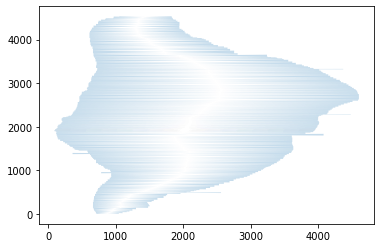

In [99]:
#PLOT SHAPE USING POLYGONS
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon


patches = []
colors = []
#example = [[[0,1],[0,2],[2,2]], [[1,1],[1,2],[3,2]] ]

for s in polys:
    patches.append(Polygon(s))

fig, ax = plt.subplots()
p = PatchCollection(patches, alpha=0.25)
ax.add_collection(p)
ax.autoscale()
plt.show()

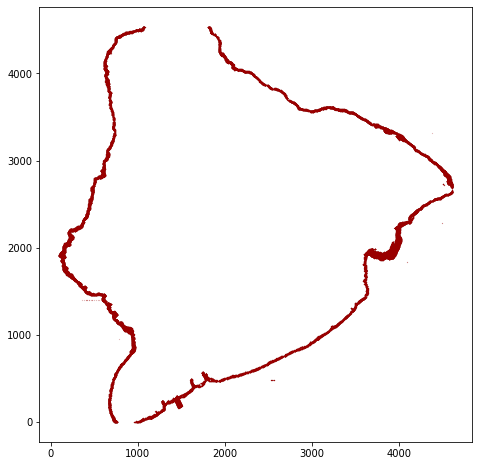

In [101]:
#PLOT ALL POINTS BY LEVEL
colors = [
    "#ffffd9",
    "#edf8b1",
    "#c7e9b4",
    "#7fcdbb",
    "#41b6c4",
    "#1d91c0",
    "#225ea8",
    "#0c2c84",
]
colors2 = [
"#fff7ec",
"#fee8c8",
"#fdd49e",
"#fdbb84",
"#fc8d59",
"#ef6548",
"#d7301f",
"#990000",
]
colors.reverse()
colors2.reverse()

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

for i,l in enumerate(levels):
    if i > 0:
        break
    data_x = [x[0] for x in level_xy[l]]
    data_y = [x[1] for x in level_xy[l]]
    plt.scatter(data_x,data_y, s=0.01, c=colors2[i])
plt.gca().set_aspect('equal', adjustable='box')

plt.show()
